In [224]:
"""
Title     : Aruba 17 Aktivitätsindex
Author    : Jan-Luca Nettingsmeier, Dimitri Dening
Created   : 21.11.2024
"""

'\nTitle     : Aruba 17 Aktivitätsindex\nAuthor    : Jan-Luca Nettingsmeier, Dimitri Dening\nCreated   : 21.11.2024\n'

In [225]:
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy

pd.options.mode.chained_assignment = None

#### Visualisierung
- Vorgehen/Ziel:
    - Nutze den neuen gesäuberten Datensatz `data_cleaned.csv`
    - Verwende Diagramme etc. um einen Ersteindruck der Daten zu bekommen
    - Betracht Motion-Sensordaten um einen Aktivitätsindex zu berechnen

In [226]:
data_cleaned_dir = "../data/aruba/data_cleaned.csv"

df_aruba = pd.read_csv(
    data_cleaned_dir,
    delimiter=",",
    header=0,
    names=[
        "date",
        "time",
        "sensor_type",
        "sensor_status",
        "datetime",
    ],
)

df_aruba["datetime"] = pd.to_datetime(df_aruba["datetime"])
display(df_aruba)
print(df_aruba.info())
df_aruba.dtypes

,date,time,sensor_type,sensor_status,datetime
0,2010-11-04,00:03:50.209589,M003,ON,2010-11-04 00:03:50.209589
1,2010-11-04,00:03:57.399391,M003,OFF,2010-11-04 00:03:57.399391
2,2010-11-04,00:15:08.984841,T002,21.5,2010-11-04 00:15:08.984841
3,2010-11-04,00:30:19.185547,T003,21,2010-11-04 00:30:19.185547
4,2010-11-04,00:30:19.385336,T004,21,2010-11-04 00:30:19.385336
...,...,...,...,...,...
1719539,2011-06-11,23:42:59.28507,T002,25.5,2011-06-11 23:42:59.285070
1719540,2011-06-11,23:48:02.888409,T001,23.5,2011-06-11 23:48:02.888409
1719541,2011-06-11,23:48:02.988798,T002,25,2011-06-11 23:48:02.988798
1719542,2011-06-11,23:53:06.4292,T002,25.5,2011-06-11 23:53:06.429200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719544 entries, 0 to 1719543
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           object        
 1   time           object        
 2   sensor_type    object        
 3   sensor_status  object        
 4   datetime       datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 65.6+ MB
None


date                     object
time                     object
sensor_type              object
sensor_status            object
datetime         datetime64[ns]
dtype: object

Hilfsfunktionen um "saubere" Datensätze zu erzeugen

In [227]:
def create_data_subset(df: pd.DataFrame, pattern: str) -> pd.DataFrame:
    df_subset = df[df["sensor_type"].str.match(pattern)]
    df_subset.loc[:, "date"] = pd.to_datetime(df_subset["date"])
    df_subset.loc[:, "datetime"] = pd.to_datetime(df_subset["datetime"], format="ISO8601")
    return df_subset


# Regex pattern for motion sensors (e.g., M001, M002, etc.)
pattern_motion_sensor = r"[M]{1}[0-9]{3,}"
pattern_temperature_sensor = r"[T]{1}[0-9]{3,}"
pattern_door_closure_sensor = r"[D]{1}[0-9]{3,}"

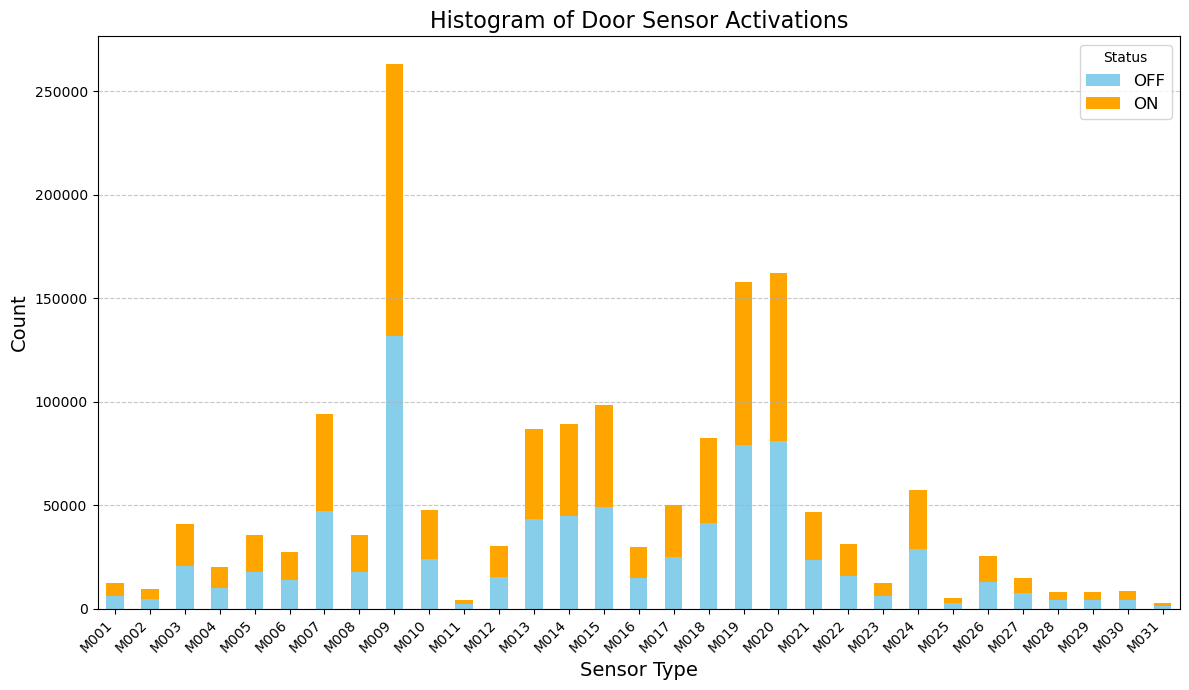

In [228]:
# Create a subset for motion sensors
df_motion_sensor = df_aruba[df_aruba["sensor_type"].str.match(pattern_motion_sensor)]

# Use pivot_table to count ON/OFF occurrences for each sensor
motion_sensor_status_counts = df_motion_sensor.pivot_table(
    index="sensor_type",
    columns="sensor_status",
    aggfunc="size",
    fill_value=0,  # Replace missing values with 0
)

# Plot the grouped data
motion_sensor_status_counts.plot(
    kind="bar",
    figsize=(12, 7),
    stacked=True,  # Stacked bar chart to show ON/OFF counts together
    color=["skyblue", "orange"],  # Colors for ON and OFF
)

# Add titles and labels
plt.title("Histogram of Door Sensor Activations", fontsize=16)
plt.xlabel("Sensor Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Status", labels=motion_sensor_status_counts.columns, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

## Berechnung des Aktivitätsindex

Der **Aktivitätsindex** beschreibt die Zeit, in der ein Sensor aktiv war (ON-Status), relativ zur Gesamtzeit eines definierten Zeitraums. Die Berechnung erfolgt in mehreren Schritten:

---

### 1. Datenstruktur verstehen
- **Zeitstempel**: Gibt den Zeitpunkt der Statusänderung (ON oder OFF) an.
- **Sensor-ID**: Z. B. „M003“ (es könnten mehrere Sensoren existieren).
- **Status**: ON (aktiv) oder OFF (inaktiv).

---

### 2. Aktivitätszeit berechnen
Für jeden Zeitraum zwischen einem **ON**- und einem **OFF**-Ereignis wird die Aktivitätsdauer berechnet:

$$
\text{Dauer} = \text{Zeitstempel}_{\text{OFF}} - \text{Zeitstempel}_{\text{ON}}
$$

#### Beispiel:
- **ON**: `2010-11-04 02:32:33.351906`  
- **OFF**: `2010-11-04 02:32:38.895958`

$$
\text{Dauer} = \text{2010-11-04 02:32:38.895958} - \text{2010-11-04 02:32:33.351906} = 5{,}544 \, \text{Sekunden}
$$

---

### 3. Gesamtzeit definieren
Definiere einen **Analysezeitraum** (z. B. pro Minute, Stunde oder Tag). In diesem Zeitraum wird die **Gesamtzeit** $T_{\text{gesamt}}$ berechnet.

---

### 4. Berechnung des Aktivitätsindex
Der Aktivitätsindex wird als Verhältnis der Zeit, in der der Sensor aktiv war, zur Gesamtzeit berechnet:

$$
\text{Aktivitätsindex} = \frac{\text{Gesamtaktivitätszeit}}{\text{Gesamtzeit}} \cdot 100
$$

#### Beispiel:
- **Analysezeitraum**: 1 Minute ($ T_{\text{gesamt}} = 60 \, \text{Sekunden} $)  
- **Sensoraktivitätszeit**: $ 5{,}544 \, \text{Sekunden} $

$$
\text{Aktivitätsindex} = \frac{5{,}544}{60} \cdot 100 = 9{,}24 \, \%
$$

---

### 5. Zusammenfassung
Für einen Sensor $ M $:
1. Addiere alle Aktivitätsdauern ( $T_{\text{aktiv}} $) im Analysezeitraum.
2. Teile $ T_{\text{aktiv}} $ durch $ T_{\text{gesamt}} $, um den Aktivitätsindex zu berechnen.

---

### 6. Erweiterung bei mehreren Sensoren
Falls mehrere Sensoren (z. B. M001, M002, ...) vorliegen:
- Berechne den Aktivitätsindex für jeden Sensor separat.
- Der **Gesamtaktivitätsindex** kann als Durchschnitt oder Summe der Aktivitätsindizes aller Sensoren berechnet werden:

$$
\text{Gesamtaktivitätsindex} = \frac{\sum_{i=1}^N \text{Aktivitätsindex}_i}{N}
$$


In [229]:
def activity_index(_df_motion_sensor: pd.DataFrame, start_date: str, end_date: str, plot: bool = True) -> pd.DataFrame:
    start_datetime = start_date
    end_datetime = end_date

    # Liste von Sensoren, für die der Aktivitätsindex berechnet werden soll (z. B. M001, M002)
    selected_sensors = []  # ["M001", "M003"]

    # Umwandeln der Zeitstempel in datetime-Objekte
    start_datetime = pd.to_datetime(start_datetime)
    end_datetime = pd.to_datetime(end_datetime)

    # Umwandeln der Datums- und Zeitspalten in einen Datetime-Typ
    df_motion_sensor = _df_motion_sensor.copy()
    df_motion_sensor["datetime"] = pd.to_datetime(df_motion_sensor["datetime"])

    # Nur Zeilen mit 'ON' und 'OFF' Status
    df_motion_sensor_on_off = df_motion_sensor[df_motion_sensor["sensor_status"].isin(["ON", "OFF"])]

    # Filtere die Daten basierend auf dem angegebenen Zeitraum
    df_motion_sensor_on_off = df_motion_sensor_on_off[
        (df_motion_sensor_on_off["datetime"] >= start_datetime) & (df_motion_sensor_on_off["datetime"] <= end_datetime)
    ]

    # Sortieren nach Zeitstempel, falls noch nicht sortiert
    df_motion_sensor_on_off = df_motion_sensor_on_off.sort_values(by="datetime")

    # Filtere nur die gewünschten Sensoren
    if len(selected_sensors) != 0:
        df_motion_sensor_on_off = df_motion_sensor_on_off[
            df_motion_sensor_on_off["sensor_type"].isin(selected_sensors)
        ]

    # Liste der einzigartigen Sensoren
    unique_sensor_type = df_motion_sensor_on_off["sensor_type"].unique()
    unique_sensor_type = sorted(unique_sensor_type, key=lambda x: int(x[1:]))

    # Dictionary zum Speichern der Aktivitätsindizes für jeden Sensor
    activity_indices = {}
    datetime = {}

    # Berechnung des Aktivitätsindex für jeden Sensor
    for sensor in unique_sensor_type:
        # Filtere nur die Daten für den aktuellen Sensor
        df_sensor = df_motion_sensor_on_off[df_motion_sensor_on_off["sensor_type"] == sensor]

        # Berechnung der aktiven Zeiten (Dauer zwischen ON und OFF)
        active_times = []

        for i in range(1, len(df_sensor)):
            # Finde Paare von ON und OFF
            if df_sensor.iloc[i - 1]["sensor_status"] == "ON" and df_sensor.iloc[i]["sensor_status"] == "OFF":
                start_time = df_sensor.iloc[i - 1]["datetime"]
                end_time = df_sensor.iloc[i]["datetime"]
                active_duration = (end_time - start_time).total_seconds()  # Dauer in Sekunden
                active_times.append(active_duration)

        # Gesamtaktive Zeit
        total_active_time = np.sum(active_times)

        # Gesamtzeit des analysierten Zeitraums (vom ersten bis zum letzten Timestamp des Sensors)
        start_time_period = df_sensor["datetime"].min()
        end_time_period = df_sensor["datetime"].max()
        total_time_period = (end_time_period - start_time_period).total_seconds()

        # Berechnung des Aktivitätsindex für den Sensor
        activity_index = (total_active_time / total_time_period) * 100

        # Speichern des Aktivitätsindex im Dictionary
        activity_indices[sensor] = activity_index

    # Daten in einem DataFrame
    activity_index = [sensor_activity[1] for sensor_activity in activity_indices.items()]
    data = {"sensor": unique_sensor_type, "activity_index": activity_index}
    df_activity = pd.DataFrame(data)

    if plot:
        try:
            # Balkendiagramm erstellen
            plt.figure(figsize=(14, 7))
            sns.barplot(
                x="sensor", y="activity_index", data=df_activity, palette="Blues_d", hue="sensor", legend=False
            )

            # Diagramm formatieren
            plt.title(
                "Aktivitätsindex der Sensoren ({s1} - {e1}) ({s2} - {e2})".format(
                    s1=start_datetime.day_name(), e1=end_datetime.day_name(), s2=start_datetime, e2=end_datetime
                ),
                fontsize=16,
            )
            plt.xlabel("Sensoren", fontsize=14)
            plt.ylabel("Aktivitätsindex (%)", fontsize=14)

            # Dynamisches Setzen der Y-Achse basierend auf dem maximalen Aktivitätsindex
            max_value = df_activity["activity_index"].max()
            plt.ylim(0, max_value + (0.1 * max_value))  # Setzt das obere Limit auf 10% mehr als der Maximalwert
        except:
            print("Not enough data")
        # Diagramm anzeigen
        plt.tight_layout()
        plt.show()

    return df_activity, activity_indices

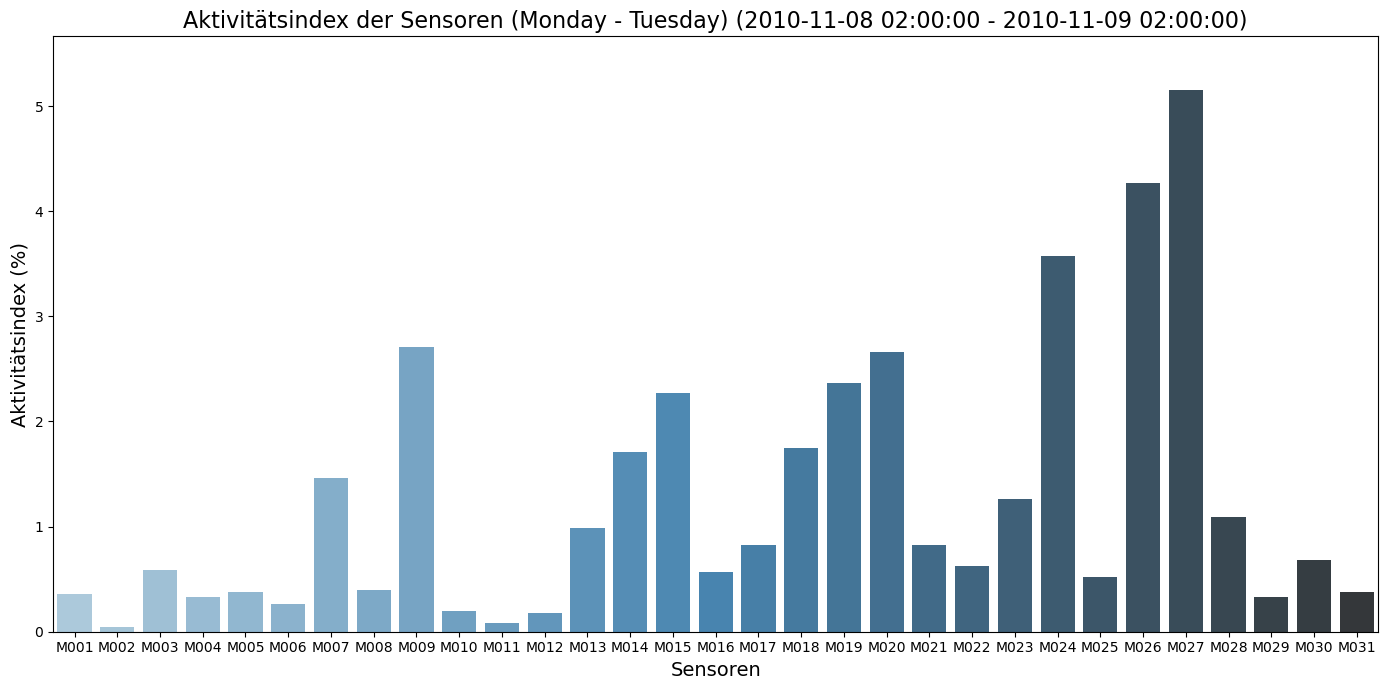

In [230]:
df_motion_sensor = create_data_subset(df_aruba, pattern_motion_sensor)

# Beispiel: Definiere den Zeitraum (Start- und Endzeit als Strings im Format 'YYYY-MM-DD HH:MM:SS')
start_datetime = "2010-11-08 02:00:00"
end_datetime = "2010-11-09 02:00:00"
df_activity_index, a_dict = activity_index(df_motion_sensor, start_datetime, end_datetime, plot=True)

# start_datetime = "2010-11-13 02:00:00"
# end_datetime = "2010-11-14 02:00:00"
# df_activity_index = activity_index(df_motion_sensor, start_datetime, end_datetime, plot=False)

#### Schlafanalyse

In [231]:
generate_sensor_list = lambda n, m: [f"M{str(i).zfill(3)}" for i in range(n, m + 1)]
motion_sensor_list = generate_sensor_list(1, 31)

filter_sensor_group = {
    "all": motion_sensor_list,
    "bedroom": ["M001", "M002", "M003", "M004", "M005", "M006", "M007"],
    "bedroom_in_bed": ["M002", "M003"],
    "bedroom_out_of_bed": ["M001", "M004", "M005", "M006", "M007"],
}

In [232]:
# Create a subset for motion sensors
df_motion_sensor = create_data_subset(df_aruba, pattern_motion_sensor)
df_motion_sensor = df_motion_sensor.reset_index(drop=True)
df_motion_sensor = df_motion_sensor.loc[df_motion_sensor["sensor_type"].isin(filter_sensor_group["bedroom"])]

# print(df_motion_sensor.info())

period = "30min"

df_activity = pd.DataFrame()

df_activity["activity"] = (
    df_motion_sensor.loc[df_motion_sensor["sensor_status"] == "ON"]
    .resample(period, on="datetime")["sensor_status"]
    .count()
)

df_activity["activity_per_sensor"] = (
    df_motion_sensor.loc[df_motion_sensor["sensor_status"] == "ON"]
    .resample(period, on="datetime")
    .apply(lambda group: group.groupby("sensor_type").size().to_dict())
)

df_activity["datetime"] = df_activity.index

df_activity = df_activity.reset_index(drop=True)
df_activity["date"] = df_activity["datetime"].dt.date
df_activity["time"] = df_activity["datetime"].dt.time

# List of weekday names
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_activity["weekday"] = df_activity["date"].apply(lambda d: days[d.weekday()])

display(df_activity)

,activity,activity_per_sensor,datetime,date,time,weekday
0,1,{'M003': 1},2010-11-04 00:00:00,2010-11-04,00:00:00,Thursday
1,0,{},2010-11-04 00:30:00,2010-11-04,00:30:00,Thursday
2,0,{},2010-11-04 01:00:00,2010-11-04,01:00:00,Thursday
3,0,{},2010-11-04 01:30:00,2010-11-04,01:30:00,Thursday
4,0,{},2010-11-04 02:00:00,2010-11-04,02:00:00,Thursday
...,...,...,...,...,...,...
10554,0,{},2011-06-11 21:00:00,2011-06-11,21:00:00,Saturday
10555,0,{},2011-06-11 21:30:00,2011-06-11,21:30:00,Saturday
10556,38,"{'M002': 12, 'M003': 6, 'M004': 2, 'M005': 2, ...",2011-06-11 22:00:00,2011-06-11,22:00:00,Saturday
10557,4,"{'M002': 2, 'M003': 2}",2011-06-11 22:30:00,2011-06-11,22:30:00,Saturday


In [233]:
filter_days = {
    "all": [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    "in_the_week": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"],
    "weekend": ["Saturday", "Sunday"],
    "mondays": ["Monday"],
    "tuesdays": ["Tuesday"],
    "wednesdays": ["Wednesday"],
    "thursdays": ["Thursday"],
    "fridays": ["Friday"],
    "saturdays": ["Saturday"],
    "sundays": ["Sunday"],
}

df_activity = df_activity.loc[df_activity["weekday"].isin(filter_days["all"])]

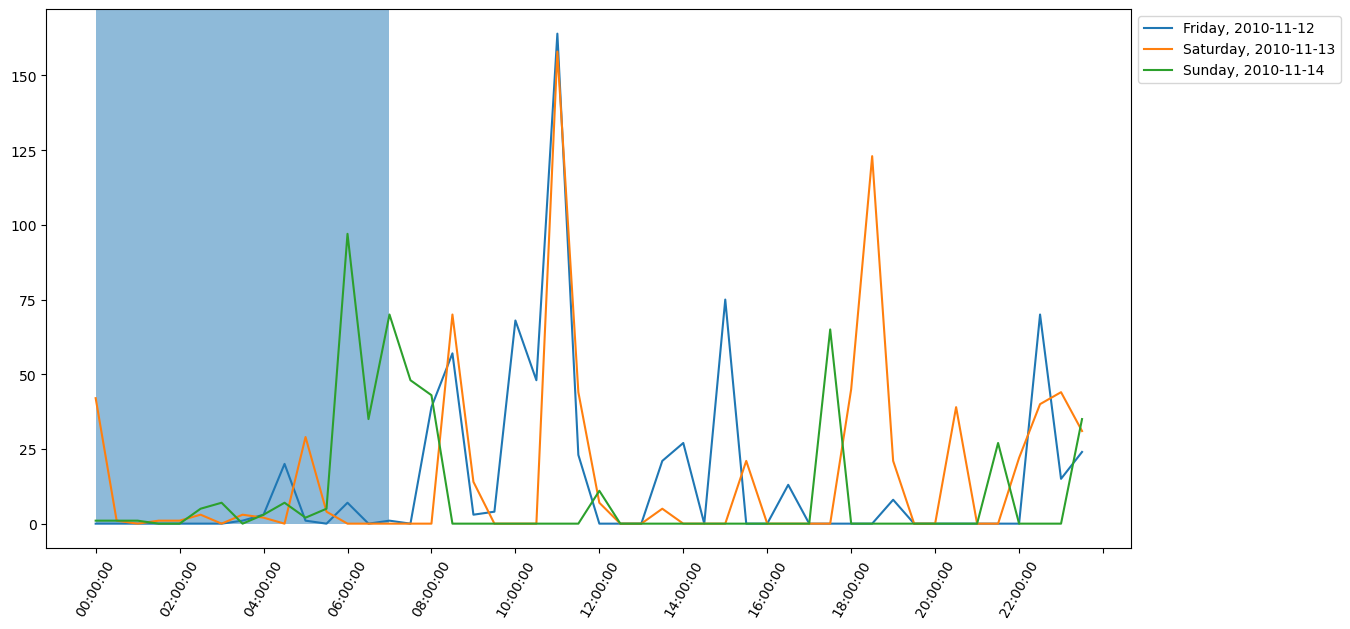

In [234]:
date_from = pd.to_datetime("2010-11-12").date()
date_to = pd.to_datetime("2010-11-14").date()

unique_dates = df_activity["date"].unique()

plt.figure(figsize=(14, 7))
ax = plt.axes()

# plot box for night
night_box = Rectangle((0, 0), 14, 2000)
pc = PatchCollection([night_box], alpha=0.5)
ax.add_collection(pc)

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
plt.xticks(rotation=60)

for date in unique_dates:
    if (date < date_from) | (date > date_to):
        continue

    df_activity_day = df_activity.loc[(df_activity["date"] == date)]
    plt.plot(
        df_activity_day["time"].apply(lambda time: time.strftime("%H:%M:%S")),
        df_activity_day["activity"],
        label=df_activity_day["weekday"].unique()[0] + ", " + date.strftime("%Y-%m-%d"),
    )

plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

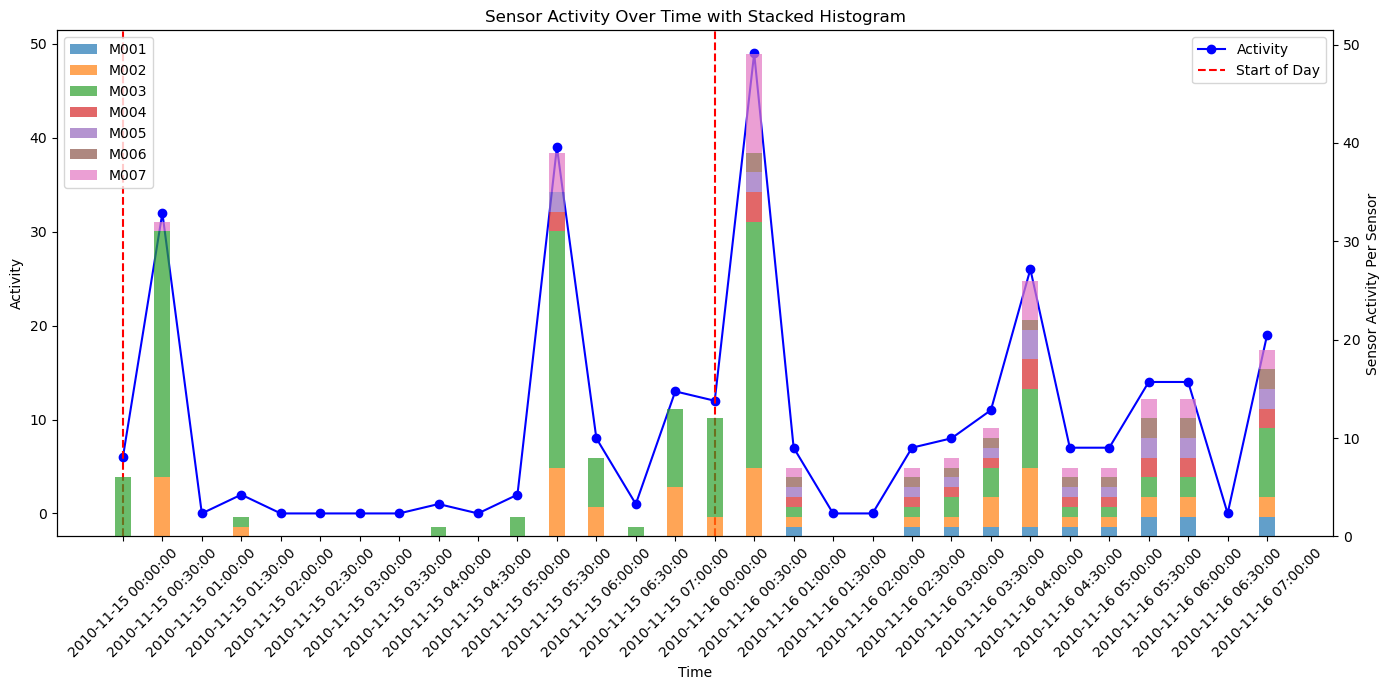

In [235]:
# Define the date and time ranges
date_from = pd.to_datetime("2010-11-15").date()
date_to = pd.to_datetime("2010-11-16").date()
time_from = pd.to_datetime("00:00:00").time()
time_to = pd.to_datetime("07:00:00").time()

# Filter data for the specified range
df_filtered = df_activity.loc[
    (df_activity["date"] >= date_from)
    & (df_activity["date"] <= date_to)
    & (df_activity["time"] >= time_from)
    & (df_activity["time"] <= time_to)
]

# Extract unique time points for x-axis
time_points = df_filtered["datetime"].apply(lambda t: t.strftime("%Y-%m-%d %H:%M:%S")).tolist()

# Prepare histogram data
sensor_columns = set()
for sensors in df_filtered["activity_per_sensor"]:
    sensor_columns.update(sensors.keys())
sensor_columns = sorted(sensor_columns)

# Create a DataFrame for stacked histogram
sensor_data = pd.DataFrame(0, index=df_filtered.index, columns=sensor_columns)
for idx, sensors in df_filtered["activity_per_sensor"].items():
    for sensor, count in sensors.items():
        sensor_data.loc[idx, sensor] = count

# Create the plot
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot the time-series data
ax1.plot(
    time_points,
    df_filtered["activity"],
    label="Activity",
    color="blue",
    marker="o",
)

# Plot the stacked histogram
bottom = np.zeros(len(sensor_data))
bar_width = 0.4
x_positions = np.arange(len(sensor_data))

for sensor in sensor_columns:
    ax2.bar(
        x_positions,
        sensor_data[sensor],
        bottom=bottom,
        label=sensor,
        width=bar_width,
        alpha=0.7,
    )
    bottom += sensor_data[sensor]

# Add vertical lines for new days
unique_dates = df_filtered["date"].unique()
for date in unique_dates:
    midnight = pd.Timestamp(f"{date} 00:00:00")
    midnight = midnight.strftime("%Y-%m-%d %H:%M:%S")
    ax1.axvline(midnight, color="red", linestyle="--", label="Start of Day" if date == unique_dates[0] else "")

# Customize axes
ax1.set_xlabel("Time")
ax1.set_ylabel("Activity")
ax2.set_ylabel("Sensor Activity Per Sensor")
ax1.set_xticks(x_positions)
ax1.set_xticklabels(time_points, rotation=45)
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")

# Title and layout adjustments
plt.title("Sensor Activity Over Time with Stacked Histogram")
plt.tight_layout()
plt.show()

- Betrachte nur Sensoren im Schlafzimmer. 
- Berechne Aktivitätsindex für diese Sensorgruppe.
- Unterscheide zwischen Sensoren im Bett und außerhalb vom Bett.
- Plotte Piechart mit Wachphase und Schlafphase

- Annahme: 
    - Im Bett: Schlafphase
    - Außerhalb vom Bett: Wachphase
    - Schlafphase = Sensorgruppe `in_bed` + Zeitdelta welches nicht von Sensoren erfasst wurde
    - Wachphase = Sensorgruppe `out_of_bed` 

In [236]:
generate_sensor_list = lambda n, m: [f"M{str(i).zfill(3)}" for i in range(n, m + 1)]
motion_sensor_list = generate_sensor_list(1, 31)

filter_sensor_group = {
    "all": motion_sensor_list,
    "bedroom": ["M001", "M002", "M003", "M004", "M005", "M006", "M007"],
    "bedroom_in_bed": ["M002", "M003"],
    "bedroom_out_of_bed": ["M001", "M004", "M005", "M006", "M007"],
}

In [237]:
# Create a subset for motion sensors
df_motion_sensor = create_data_subset(df_aruba, pattern_motion_sensor)
df_motion_sensor = df_motion_sensor.reset_index(drop=True)

df_motion_sensor.loc[:, "date"] = pd.to_datetime(df_motion_sensor["datetime"]).dt.date
df_motion_sensor.loc[:, "time"] = (
    pd.to_datetime(df_motion_sensor["datetime"], format="%H:%M:%S.%f").dt.floor("S").dt.time
)

df_bedroom_in_bed = df_motion_sensor.loc[df_motion_sensor["sensor_type"].isin(filter_sensor_group["bedroom_in_bed"])]

df_bedroom_out_of_bed = df_motion_sensor.loc[
    df_motion_sensor["sensor_type"].isin(filter_sensor_group["bedroom_out_of_bed"])
]

/tmp/ipykernel_977/96061544.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  pd.to_datetime(df_motion_sensor["datetime"], format="%H:%M:%S.%f").dt.floor("S").dt.time


In [238]:
# Define the date and time ranges
date_from = pd.to_datetime("2010-11-15").date()
date_to = pd.to_datetime("2010-11-16").date()
time_from = pd.to_datetime("00:00:00").time()
time_to = pd.to_datetime("07:00:00").time()


def sleep_activity_index(df_input: pd.DataFrame, show_output: bool = True) -> tuple:
    df_copy = df_input.copy()

    # Filter data for the specified range
    df_filtered = df_copy[
        (df_copy["date"] >= date_from)
        & (df_copy["date"] <= date_to)
        & (df_copy["time"] >= time_from)
        & (df_copy["time"] <= time_to)
    ]

    # Ensure data is sorted by sensor and datetime
    df_filtered = df_filtered.sort_values(by=["sensor_type", "datetime"])

    # Initialize an empty list to store results
    results = []

    # Group by each sensor and process
    for sensor, group in df_filtered.groupby("sensor_type"):
        # Reset index for easier access
        group = group.reset_index(drop=True)

        # Iterate through the group to find ON-OFF pairs
        for i in range(len(group) - 1):
            if group.loc[i, "sensor_status"] == "ON" and group.loc[i + 1, "sensor_status"] == "OFF":
                duration = (group.loc[i + 1, "datetime"] - group.loc[i, "datetime"]).total_seconds()
                results.append(
                    {
                        "sensor_type": sensor,
                        "activation_count": 1,
                        "total_active_duration": duration,
                        "datetime": group.loc[i, "datetime"],
                        "next_datetime": group.loc[i + 1, "datetime"],
                        "date": group.loc[i, "date"],
                        "time": group.loc[i, "time"],
                        "sensor_status": group.loc[i, "sensor_status"],
                    }
                )

    # Combine results into a summary DataFrame
    df_sleep_activity = pd.DataFrame(results)
    df_sleep_activity_index = pd.DataFrame()

    # display(df_sleep_activity)

    # Find the total time window for the sensor
    total_time_period = (df_filtered["datetime"].max() - df_filtered["datetime"].min()).total_seconds()

    # Aggregate by sensor_type
    if not df_sleep_activity.empty:
        sensor_summary = (
            df_sleep_activity.groupby("sensor_type")
            .agg(activation_count=("activation_count", "sum"), total_active_duration=("total_active_duration", "sum"))
            .reset_index()
        )

        # Add total_time_period as a constant column
        sensor_summary["total_time_period"] = total_time_period

        # Calculate activity_index
        sensor_summary["activity_index"] = (
            sensor_summary["total_active_duration"] / sensor_summary["total_time_period"]
        ) * 100

        df_sleep_activity_index = pd.DataFrame(sensor_summary)

    if show_output:
        display(df_sleep_activity_index)

    return (df_sleep_activity_index, df_sleep_activity)


df_bedroom_in_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_in_bed)

df_bedroom_out_of_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_out_of_bed)

,sensor_type,activation_count,total_active_duration,total_time_period,activity_index
0,M002,44,7851.649183,110407.251079,7.111534
1,M003,121,8196.612029,110407.251079,7.423980


,sensor_type,activation_count,total_active_duration,total_time_period,activity_index
0,M001,11,7772.854235,108895.850686,7.137879
1,M004,18,7737.599309,108895.850686,7.105504
2,M005,17,7781.998394,108895.850686,7.146276
3,M006,13,7772.407948,108895.850686,7.137469
4,M007,29,7843.474800,108895.850686,7.202731


Visualisierung vom Schlafverhalten

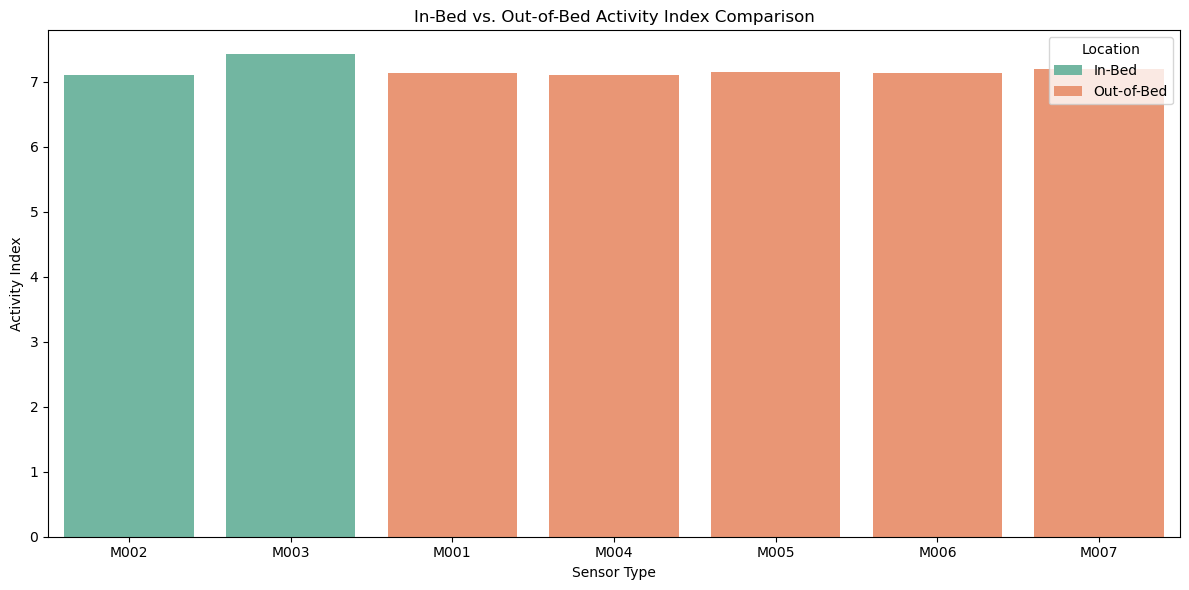

In [239]:
# Combine the data for visualization
in_bed = df_bedroom_in_bed_sleep_activity_index.assign(location="In-Bed")
out_of_bed = df_bedroom_out_of_bed_sleep_activity_index.assign(location="Out-of-Bed")
comparison_df = pd.concat([in_bed, out_of_bed])

# Create a grouped bar chart for "In-Bed" vs. "Out-of-Bed" comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x="sensor_type", y="activity_index", hue="location", palette="Set2")
plt.title("In-Bed vs. Out-of-Bed Activity Index Comparison")
plt.xlabel("Sensor Type")
plt.ylabel("Activity Index")
plt.legend(title="Location")
plt.tight_layout()
plt.show()

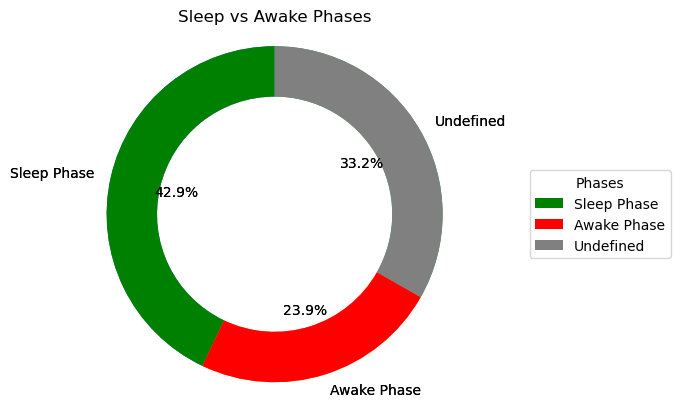

In [240]:
def plot_sleep_awake_ratio(
    df_bedroom_in_bed_sleep_activity_index: pd.DataFrame, df_bedroom_out_of_bed_sleep_activity_index: pd.DataFrame
) -> None:
    total_activity_in_bed = df_bedroom_in_bed_sleep_activity_index["activity_index"].sum()
    total_activity_out_of_bed = df_bedroom_out_of_bed_sleep_activity_index["activity_index"].sum()

    undefined_activity = abs(100 - (total_activity_in_bed + total_activity_out_of_bed))
    total_activity_in_bed = undefined_activity + total_activity_in_bed

    # Labels and data
    labels = ["Sleep Phase", "Awake Phase", "Undefined"]
    sleep_phase = total_activity_in_bed
    awake_phase = total_activity_out_of_bed
    data = [sleep_phase, awake_phase, undefined_activity]

    # Create a pie chart
    fig, ax = plt.subplots()
    ax.pie(data, labels=labels, autopct="%1.1f%%", startangle=90, wedgeprops={"width": 0.3})

    # Add a legend on the side
    wedges, texts, autotexts = ax.pie(
        data,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        wedgeprops={"width": 0.3},
        textprops={"fontsize": 10},
        colors=["green", "red", "grey"],
    )

    ax.legend(wedges, labels, title="Phases", loc="center left", bbox_to_anchor=(1, 0.5))
    ax.axis("equal")
    plt.title("Sleep vs Awake Phases")
    plt.show()


plot_sleep_awake_ratio(df_bedroom_in_bed_sleep_activity_index, df_bedroom_out_of_bed_sleep_activity_index)

##### Betrachtung des Schlafverhalten über einen Monat
- Bestimme den Durchschnitt für die Wach- und Schlafphase für den ersten Monat
- Nutze diesen Wert um eine Aussage über die Schlafaktivität im allgemeinen zu treffen
- Was lässt sich beobachten?
    - verschlechtert/verbessert sich der Schlafanteil über die Zeit?
    - bleibt der Schlafanteil konstant?
    - ...
- Problem:
    - 1: (?) `plot_sleep_awake_ratio` liefert nur korrekte Daten für den Aktivitätsindex für einen Tag. Die Schlafphase wird nur in der Zeit von 00:00 - 07:00 betrachtet. 
    - Berechnung erfolgt über den gesamten Zeitraum $\Rightarrow$ viel Leerlauf   
    - 2: (?) Gesäuberter Datensatz ist teilweise fehlerhaft. Das Ersetzen von z.B. OFFc mit OFF führt zu fehlerhaften Datensatz 
    

##### Bestimme Mittelwert über einen Monat

In [241]:
# Define the date and time ranges
date_from = pd.to_datetime("2010-11-04").date()
date_to = pd.to_datetime("2010-11-30").date()
time_from = pd.to_datetime("00:00:00").time()
time_to = pd.to_datetime("07:00:00").time()

# Workaround for problem #1: Generate a range of dates
date_range = pd.date_range(start=date_from, end=date_to)
date_list = date_range.date.tolist()
# Remove date with faulty data
date_list.remove(pd.to_datetime("2010-11-16").date())

total_duration_in_bed = 0
total_duration_out_of_bed = 0

for date in date_list:
    date_from = date
    date_to = date

    df_bedroom_in_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_in_bed, show_output=False)

    total_duration_in_bed += df_bedroom_in_bed_sleep_activity_index["total_active_duration"].sum()

    df_bedroom_out_of_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_out_of_bed, show_output=False)

    total_duration_out_of_bed += df_bedroom_out_of_bed_sleep_activity_index["total_active_duration"].sum()

    # plot_sleep_awake_ratio(df_bedroom_in_bed_sleep_activity_index, df_bedroom_out_of_bed_sleep_activity_index)

mean_sleep = total_duration_in_bed / (len(date_list))
mean_awake = total_duration_out_of_bed / (len(date_list))
print("Mean Sleep Time Per Day: ", mean_sleep)
print("Mean Awake Time Per Day: ", mean_awake)

Mean Sleep Time Per Day:  282.0572698846153
Mean Awake Time Per Day:  169.23813630769232


##### Trend (Probe)
- Anomalie am 16.11.2010

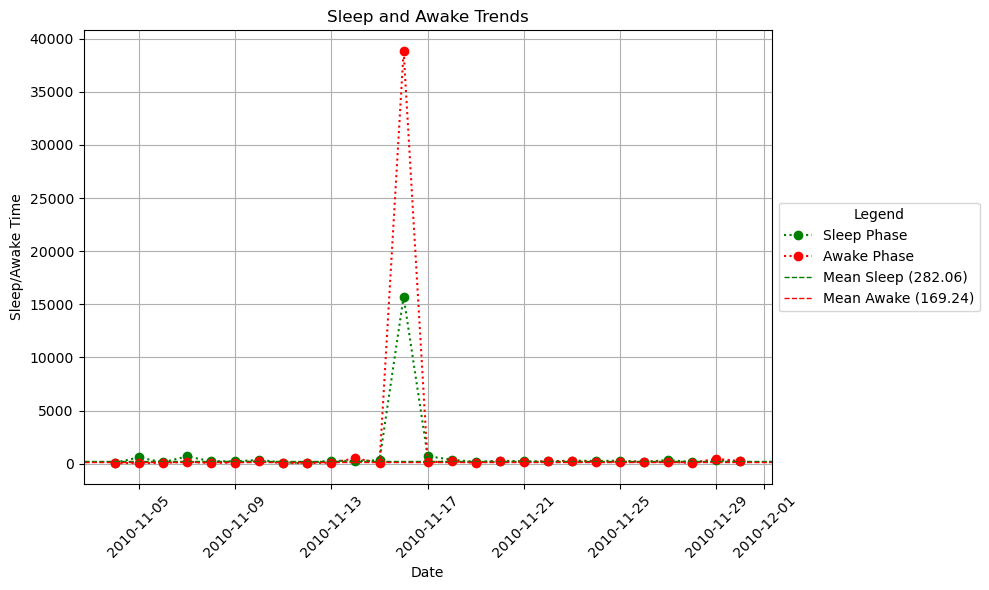

In [242]:
# Define the date and time ranges
date_from = pd.to_datetime("2010-11-04").date()
date_to = pd.to_datetime("2010-11-30").date()
time_from = pd.to_datetime("00:00:00").time()
time_to = pd.to_datetime("07:00:00").time()

# Workaround for problem #1: Generate a range of dates
date_range = pd.date_range(start=date_from, end=date_to)
date_list = date_range.date.tolist()

# Plot the data
plt.figure(figsize=(10, 6))

data_in_bed = []
data_ouf_of_bed = []

for date in date_list:
    date_from = date
    date_to = date

    df_bedroom_in_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_in_bed, show_output=False)
    df_bedroom_out_of_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_out_of_bed, show_output=False)

    if not df_bedroom_in_bed_sleep_activity_index.empty:
        data_in_bed.append(df_bedroom_in_bed_sleep_activity_index["total_active_duration"].sum())
    else:
        data_in_bed.append(0)

    if not df_bedroom_out_of_bed_sleep_activity_index.empty:
        data_ouf_of_bed.append(df_bedroom_out_of_bed_sleep_activity_index["total_active_duration"].sum())
    else:
        data_ouf_of_bed.append(0)


plt.plot(date_list, data_in_bed, color="green", marker="o", linestyle="dotted", label="Sleep Phase")
plt.plot(date_list, data_ouf_of_bed, color="red", marker="o", linestyle="dotted", label="Awake Phase")

# Add mean lines
plt.axhline(mean_sleep, color="green", linestyle="--", linewidth=1, label=f"Mean Sleep ({mean_sleep:.2f})")
plt.axhline(mean_awake, color="red", linestyle="--", linewidth=1, label=f"Mean Awake ({mean_awake:.2f})")

plt.title("Sleep and Awake Trends")
plt.xlabel("Date")
plt.ylabel("Sleep/Awake Time")
plt.legend()
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Legend")

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

##### Trend November (ohne Anomalie)

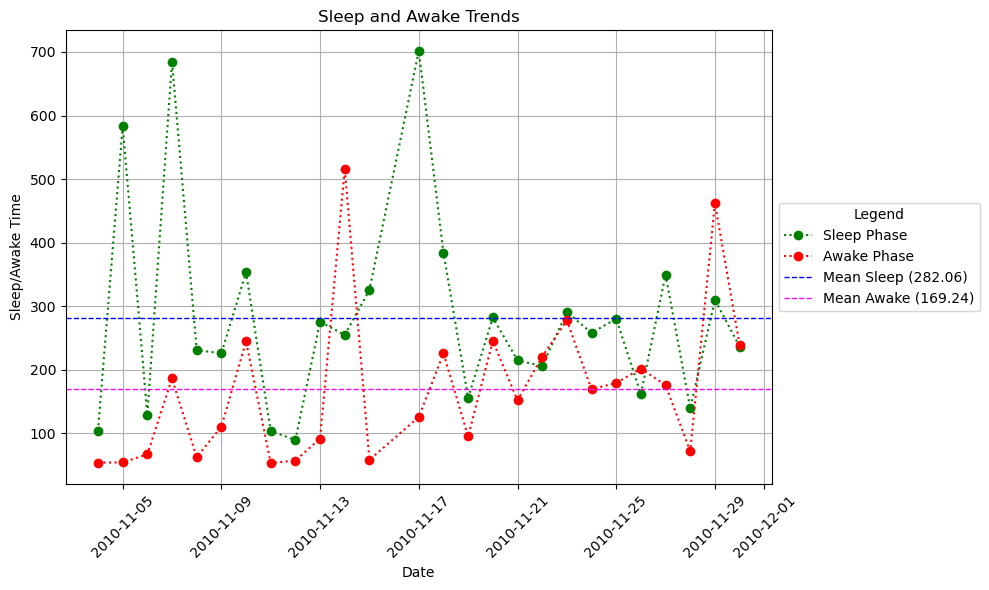

In [243]:
# Define the date and time ranges
date_from = pd.to_datetime("2010-11-04").date()
date_to = pd.to_datetime("2010-11-30").date()
time_from = pd.to_datetime("00:00:00").time()
time_to = pd.to_datetime("07:00:00").time()

# Workaround for problem #1: Generate a range of dates
date_range = pd.date_range(start=date_from, end=date_to)
date_list = date_range.date.tolist()
# Remove date with faulty data
date_list.remove(pd.to_datetime("2010-11-16").date())

# Plot the data
plt.figure(figsize=(10, 6))

data_in_bed = []
data_ouf_of_bed = []

for date in date_list:
    date_from = date
    date_to = date

    df_bedroom_in_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_in_bed, show_output=False)
    df_bedroom_out_of_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_out_of_bed, show_output=False)

    if not df_bedroom_in_bed_sleep_activity_index.empty:
        data_in_bed.append(df_bedroom_in_bed_sleep_activity_index["total_active_duration"].sum())
    else:
        data_in_bed.append(0)

    if not df_bedroom_out_of_bed_sleep_activity_index.empty:
        data_ouf_of_bed.append(df_bedroom_out_of_bed_sleep_activity_index["total_active_duration"].sum())
    else:
        data_ouf_of_bed.append(0)


plt.plot(date_list, data_in_bed, color="green", marker="o", linestyle="dotted", label="Sleep Phase")
plt.plot(date_list, data_ouf_of_bed, color="red", marker="o", linestyle="dotted", label="Awake Phase")

# Add mean lines
plt.axhline(mean_sleep, color="blue", linestyle="--", linewidth=1, label=f"Mean Sleep ({mean_sleep:.2f})")
plt.axhline(mean_awake, color="magenta", linestyle="--", linewidth=1, label=f"Mean Awake ({mean_awake:.2f})")

plt.title("Sleep and Awake Trends")
plt.xlabel("Date")
plt.ylabel("Sleep/Awake Time")
plt.legend()
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Legend")

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

##### Trend für Dezember

[0, 186.69590499999998, 138.953285, 79.252061, 193.707447, 86.406657, 102.81962000000001, 51.566907, 364.356678, 235.6099, 161.318887, 475.870862, 233.419687, 75.234889, 247.24041300000002, 188.104966, 45.331842, 346.147406, 115.75581199999999, 109.646852, 189.012919, 202.322919, 194.99874599999998, 178.333086, 750.758448, 185.860618, 0, 309.89497, 102.039784, 237.032106, 158.960577]


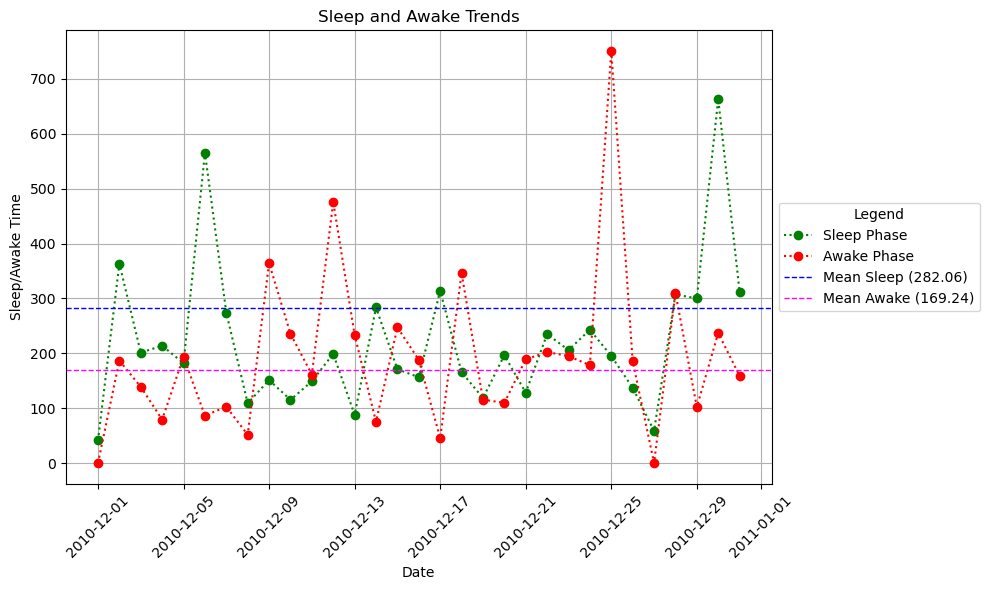

In [244]:
# Define the date and time ranges
date_from = pd.to_datetime("2010-12-01").date()
date_to = pd.to_datetime("2010-12-31").date()
time_from = pd.to_datetime("00:00:00").time()
time_to = pd.to_datetime("07:00:00").time()

# Workaround for problem #1: Generate a range of dates
date_range = pd.date_range(start=date_from, end=date_to)
date_list = date_range.date.tolist()

# Plot the data
plt.figure(figsize=(10, 6))

data_in_bed = []
data_ouf_of_bed = []

for date in date_list:
    date_from = date
    date_to = date

    df_bedroom_in_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_in_bed, show_output=False)
    df_bedroom_out_of_bed_sleep_activity_index, _ = sleep_activity_index(df_bedroom_out_of_bed, show_output=False)

    if not df_bedroom_in_bed_sleep_activity_index.empty:
        data_in_bed.append(df_bedroom_in_bed_sleep_activity_index["total_active_duration"].sum())
    else:
        data_in_bed.append(0)

    if not df_bedroom_out_of_bed_sleep_activity_index.empty:
        data_ouf_of_bed.append(df_bedroom_out_of_bed_sleep_activity_index["total_active_duration"].sum())
    else:
        data_ouf_of_bed.append(0)


print(data_ouf_of_bed)
plt.plot(date_list, data_in_bed, color="green", marker="o", linestyle="dotted", label="Sleep Phase")
plt.plot(date_list, data_ouf_of_bed, color="red", marker="o", linestyle="dotted", label="Awake Phase")

# Add mean lines
plt.axhline(mean_sleep, color="blue", linestyle="--", linewidth=1, label=f"Mean Sleep ({mean_sleep:.2f})")
plt.axhline(mean_awake, color="magenta", linestyle="--", linewidth=1, label=f"Mean Awake ({mean_awake:.2f})")

plt.title("Sleep and Awake Trends")
plt.xlabel("Date")
plt.ylabel("Sleep/Awake Time")
plt.legend()
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Legend")

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()